In [3]:
from meshed.slabs import Slabs

from statistics import stdev
vol = stdev
should_turn_movement_sensor_on = lambda audio, light: vol(audio) * light > 50000

def make_a_slabs_iter():

    # Mocking the sensor readers
    audio_sensor_read = iter([[1, 2, 3], [-96, 87, -92], [320, -96, 99]]).__next__
    light_sensor_read = iter([126, 501, 523]).__next__
    movement_sensor_read = iter([None, None, True]).__next__

    return Slabs(
        # The first three components get data from the sensors.
        # The *_read objects are all callable, returning the next
        # chunk of data for that sensor, if any.
        audio=audio_sensor_read,
        light=light_sensor_read,
        movement=movement_sensor_read,
        # The next
        should_turn_movement_sensor_on = lambda audio, light: vol(audio) * light > 50000,
        human_presence_score = lambda audio, light, movement: movement and sum([vol(audio), light]),
        should_notify = lambda human_presence_score: human_presence_score and human_presence_score > 700,
        notify = lambda should_notify: print('someone is there') if should_notify else None
    )


si = make_a_slabs_iter()
next(si)  
    

{'audio': [1, 2, 3],
 'light': 126,
 'movement': None,
 'should_turn_movement_sensor_on': False,
 'human_presence_score': None,
 'should_notify': None,
 'notify': None}

In [4]:
next(si)

{'audio': [-96, 87, -92],
 'light': 501,
 'movement': None,
 'should_turn_movement_sensor_on': True,
 'human_presence_score': None,
 'should_notify': None,
 'notify': None}

In [5]:
next(si)

someone is there


{'audio': [320, -96, 99],
 'light': 523,
 'movement': True,
 'should_turn_movement_sensor_on': True,
 'human_presence_score': 731.1353726143957,
 'should_notify': True,
 'notify': None}

# Slabs for stamping press

In [89]:
from meshed.slabs import Slabs
from more_itertools import windowed

from typing import Callable

last_plc = None
def filter_on_predicate(data, pred: Callable, event):
    if event is None:
        return 'out1'
    if pred(event):
        return data
    else: 
        return 'out1'

def event_switch(event):
    event['event_a']

def demux(accel, plc):
    result = 'out_1'
    if plc['event_a']:
        result = accel
    return filter_on_predicate(accel, event_switch, plc)


def my_iterator(obj, step = 10):
    for i in range(0, 30, step):
        print(f'{i=}, {i+step=}')
        yield obj[i:i+step]

def make_a_slabs_iter():
    # Sensor readers, slabs of 1 sec
    # use next_slice of creek InfiniteStream instead of iter
    #accelerometer_sensor_read = iter([{'ch1':1, 'ch2':2, 'ch3':3, 'ts':001}, {'ch1':-2, 'ch2':22, 'ch3':43, 'ts':002},
    #                                  {'ch1':92, 'ch2':94, 'ch3':95, 'ts':003}]).__next__
    accelerometer_sensor_read = iter([{'ch1':1, 'ch2':2, 'ch3':3, 'ts':0},{'ch1':1, 'ch2':2, 'ch3':3, 'ts':10}, 
                                             {'ch1':-2, 'ch2':22, 'ch3':43, 'ts':20},{'ch1':92, 'ch2':94, 'ch3':95, 'ts':30},
                                             {'ch1':92, 'ch2':94, 'ch3':95, 'ts':40}])
    accel_buffer = my_iterator(TimestampedInfiniteSequence(accelerometer_sensor_read, buffer_len = 2)).__next__

    # change to an iterator on slices, from 10 to 10
    plc_read = iter([{'var_a':False, 'var_b':False,'ts':0},{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':10}, 
                        {'var_a':True, 'var_b':True,'ts':15},{'var_a':True, 'var_b':True,'ts':20},
                        {'var_a':True, 'var_b':True,'ts':25},{'var_a':False, 'var_b':True,'ts':30},
                        {'var_a':False, 'var_b':True,'ts':35},{'var_a':False, 'var_b':True,'ts':40}])
    plc_buffer = my_iterator(TimestampedInfiniteSequence(plc_read, buffer_len = 3)).__next__
    
    # pb: what to do with different sample rates? events at the same time! {event_a, event_b}
    return Slabs(
        accel=accel_buffer,
        plc=plc_buffer,
        store_last_plc = lambda plc: set_last_plc(plc[-1]),
        plc_event= lambda plc: list(detect_difference(plc)),
        #demux = lambda accel, plc: filter_on_predicate(accel, event_switch, plc),
        #buffer = lambda demux: windowed(demux, n=2)
    )

def detect_difference(arr):
    if last_plc['var_a'] != arr[0]['var_a']:
        yield 'event_a'
    for x,y in zip(arr, arr[1:]):
        if x['var_a'] != y['var_a']:
            yield 'event_a'

def set_last_plc(value):
    global last_plc    
    last_plc = value



s = make_a_slabs_iter()
next(s)
#next(s)

i=0, i+step=10
i=0, i+step=10


{'accel': [{'ch1': 1, 'ch2': 2, 'ch3': 3, 'ts': 0}],
 'plc': [{'var_a': False, 'var_b': False, 'ts': 0},
  {'var_a': False, 'var_b': False, 'ts': 5}],
 'store_last_plc': None,
 'plc_event': []}

In [90]:
next(s)

i=10, i+step=20
i=10, i+step=20


{'accel': [{'ch1': 1, 'ch2': 2, 'ch3': 3, 'ts': 10}],
 'plc': [{'var_a': True, 'var_b': False, 'ts': 10},
  {'var_a': True, 'var_b': True, 'ts': 15}],
 'store_last_plc': None,
 'plc_event': []}

In [91]:
next(s)

i=20, i+step=30
i=20, i+step=30


{'accel': [{'ch1': -2, 'ch2': 22, 'ch3': 43, 'ts': 20}],
 'plc': [{'var_a': True, 'var_b': True, 'ts': 20},
  {'var_a': True, 'var_b': True, 'ts': 25}],
 'store_last_plc': None,
 'plc_event': []}

In [92]:
next(s)

StopIteration: 

In [9]:
# sample rate must be the same
# events can occur at the same time
# Valentin: use creek

In [82]:
#Valentin's code
from dataclasses import dataclass
from typing import Iterator
from creek.infinite_sequence import BufferedGetter, OverlapsPastError
from itertools import islice


@dataclass
class TimestampedInfiniteSequence:

    iterator: Iterator
    buffer_len: int

    def __post_init__(self):
        self.buffer_getter = BufferedGetter(self.buffer_len)

    def __getitem__(self, item):
        if isinstance(item, slice):
            items = list(self.buffer_getter)
            
            if not len(items):
                self.buffer_getter.extend(islice(self.iterator, 1))
                return self.__getitem__(item)
            #buffer = AudioData.concatenate(items)
            if item.stop > items[-1]['ts']: #item must have a ts attribute
                self.buffer_getter.extend(islice(self.iterator, 1))
                return self.__getitem__(item)
            if item.start < items[0]['ts']:
                raise OverlapsPastError(
                    f'wrong range'
                    #f'You asked for {item}, but the buffer only contains the index range: {items.start_date}:{items.end_date}'
                )
            
            def query(i: dict):
                #print(f'{item.start=}, {item.stop=}, {i["ts"]=}')
                return item.start <= i['ts'] < item.stop
            
            return self.buffer_getter[query]
        elif isinstance(item, int):
            return self[slice(item, item + 1)][0]

In [54]:
accelerometer_sensor_iter = iter([{'ch1':1, 'ch2':2, 'ch3':3, 'ts':0},{'ch1':1, 'ch2':2, 'ch3':3, 'ts':10}, {'ch1':-2, 'ch2':22, 'ch3':43, 'ts':20},{'ch1':92, 'ch2':94, 'ch3':95, 'ts':30},{'ch1':92, 'ch2':94, 'ch3':95, 'ts':40}])
accel_buffer = TimestampedInfiniteSequence(accelerometer_sensor_iter, buffer_len = 3)

#plc_sensor_iter = iter([{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':21}, {'var_a':False, 'var_b':True,'ts':32}])
plc_sensor_iter = iter([{'var_a':False, 'var_b':False,'ts':5}, {'var_a':True, 'var_b':False,'ts':10}, 
                        {'var_a':False, 'var_b':True,'ts':15},{'var_a':False, 'var_b':True,'ts':20},
                        {'var_a':False, 'var_b':True,'ts':25},{'var_a':False, 'var_b':True,'ts':30},
                        {'var_a':False, 'var_b':True,'ts':35},{'var_a':False, 'var_b':True,'ts':40}])

plc_buffer = TimestampedInfiniteSequence(plc_sensor_iter, buffer_len = 3)


In [52]:
# check the ranges
print(accel_buffer[20:30])

[{'ch1': -2, 'ch2': 22, 'ch3': 43, 'ts': 20}, {'ch1': 92, 'ch2': 94, 'ch3': 95, 'ts': 30}]


In [53]:
print(plc_buffer[20:30])

[{'var_a': False, 'var_b': True, 'ts': 20}, {'var_a': False, 'var_b': True, 'ts': 25}, {'var_a': False, 'var_b': True, 'ts': 30}]


In [7]:
from meshed import code_to_dag

@code_to_dag
def user_story():
    audio = audio_sensor_read(audio_source)
    light = light_sensor_read(light_source)
    result = myfunc(audio, light)
    final = f(result)
    dead_node = my_func2(audio, light)
    



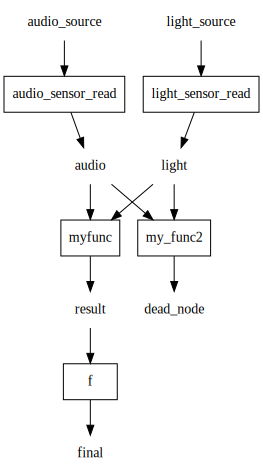

In [8]:
user_story.dot_digraph()

In [52]:
s = make_a_slabs_iter()

In [54]:
list(next(s)['buffer'])

[('ch1', 'ch2'), ('ch2', 'ch3')]

In [36]:
from more_itertools import windowed

In [37]:
all_windows = windowed([1, 2, 3, 4, 5], 3)
list(all_windows)
[(1, 2, 3), (2, 3, 4), (3, 4, 5)]

[(1, 2, 3), (2, 3, 4), (3, 4, 5)]

# Scrap

In [ ]:
# reactive programming in slabs
# start with reading the plc
# do  the async stuff
# you buffer the plc
# how to solve the backpressure problem?
# if None: we do not ignore the input (slabs is a function)
# handling the signals: check the notes
# in meshed: get exceptions